# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [268]:
import pandas as pd

In [269]:
import warnings
warnings.filterwarnings('ignore')

In [270]:
try:
    data = pd.read_csv('/da..ta.csv') # Yandex path
except:
    data = pd.read_csv("da...r.csv") # personal path

In [272]:
data.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### 12 колонок, 21525 строк
- children - дети. челочисленное. есть данные по всем строкам
- days_employed - трудовой стаж в днях. численное значение. есть пропуски данных
- dob_years - возраст клиента, целочисленное. есть все строки
- education - образование. текст. вроде бы без пропусков. надо посмотреть уники
- education_id - целочисленный идентификатор образования. можно сделать словарь
- family_status - семейное положение. текст. 
- family_status_id - целочисленный идентификатор семейного положения. можно сделать словарь
- gender - пол клиента. текст. хорошо бы проверить уники
- income_type - тип занятости. текст. возможно словарь
- debt - имел ли задолженность по возврату. целочисленное. возможно, булевое
- total_income - ежемесячный доход - численное. есть пропуски
- purpose - цель получения кредита - текстовое. возможен словарь

## Проверим пропуски

In [273]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Интересное совпадение - 2174 пропуска в трудовом стаже и в ежемесячном доходе

## Посмотрим доли отсутствующих значений 

In [274]:
round(data.isna().sum() * 100 / len(data), 2)

children            0.00
days_employed      10.10
dob_years           0.00
education           0.00
education_id        0.00
family_status       0.00
family_status_id    0.00
gender              0.00
income_type         0.00
debt                0.00
total_income       10.10
purpose             0.00
dtype: float64

Пропуски данных составляют 10%

## Сводная информация по _параметрам_ данных

In [275]:
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","19,351.00"
mean,0.54,"63,046.50",43.29,0.82,0.97,0.08,"167,422.30"
std,1.38,"140,827.31",12.57,0.55,1.42,0.27,"102,971.57"
min,-1.00,"-18,388.95",0.00,0.00,0.00,0.00,"20,667.26"
25%,0.00,"-2,747.42",33.00,1.00,0.00,0.00,"103,053.15"
50%,0.00,"-1,203.37",42.00,1.00,0.00,0.00,"145,017.94"
75%,1.00,-291.10,53.00,1.00,1.00,0.00,"203,435.07"
max,20.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03"


# Далее - прорабатываем данные по колонкам

## 1. children - количество детей

### проверим на уникальность 

In [276]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

#### С количеством детей не всё в порядке.
1. Отрицательное значение - это описка. надо внести то же значение, но положительное
2. Огромное значение - 20! Тоже описка... Удалить лишний НОЛЬ в записи 
Делаем:

In [277]:
# ЗАМЕНА ОТРИЦАТЕЛЬНОГО ЗНАЧЕНИЯ
data.loc[data['children'] == -1, 'children'] = 1
data['children'].unique()

array([ 1,  0,  3,  2,  4, 20,  5])

-1 успешно заменил на 1
Теперь черёд за 20

In [278]:
data.loc[data['children'] == 20, 'children'] = 2
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

#### Количество детей - в норме!

    Посмотрим распределение количества детей в выборке

<AxesSubplot:ylabel='Frequency'>

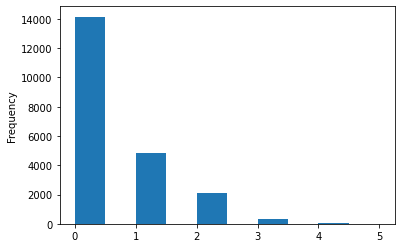

In [279]:
childrens = data['children']

childrens.plot(kind='hist')

### 2. days_employed - трудовой стаж.


из проверки пропуском известно, что данные по трудовому стажу содержат ~10% пропусков

### проверим на уникальность 

In [280]:
# посмотрим список снизу
sorted(data['days_employed'].unique())

[-18388.949900568383,
 -17615.563265627912,
 -16593.472817263817,
 -15835.725774811905,
 -15785.678893355005,
 -15773.0613349239,
 -14051.20262056069,
 -13894.357289777596,
 -13025.425448134729,
 -12930.541677797675,
 -12785.542677341233,
 -12587.262898873396,
 -12401.233338542044,
 -12392.30937376918,
 -12136.131380846335,
 -12118.379735167442,
 -12111.680980751775,
 -11991.292307711721,
 -11986.106782911937,
 -11812.14035982973,
 -11618.566681617605,
 -11535.793753711898,
 -11483.095999199346,
 -11285.562241160947,
 -11281.47323346874,
 -11278.180447381976,
 -11160.551333435369,
 -11109.782505618114,
 -11001.589092067063,
 -10836.555588720423,
 -10585.567475865855,
 -10467.60071133001,
 -10433.32086747994,
 -10186.771682419445,
 -10080.60539363857,
 -10061.740619415676,
 -10038.818548915877,
 -10029.280777701162,
 -9973.979750576918,
 -9959.399532274549,
 -9923.896675736321,
 -9854.773564031651,
 -9776.519787488136,
 -9746.37271428679,
 -9725.456696975145,
 -9686.561022482496,
 -9659

In [281]:
# посмотрим список сверху
sorted(data['days_employed'].unique(), reverse=True)

[401755.40047533,
 401715.8117488882,
 401675.093433862,
 401674.4666333656,
 401663.8500458008,
 401635.0326971183,
 401619.6332980906,
 401614.47562223615,
 401591.8284573659,
 401590.452230711,
 401575.19672763156,
 401573.9052883258,
 401556.7535504825,
 401524.25915292674,
 401517.2763879868,
 401486.70674559905,
 401458.8777808532,
 401446.44671989843,
 401440.83433553757,
 401381.7361559379,
 401378.57076131686,
 401371.3597884085,
 401369.48360249796,
 401364.8528819214,
 401345.92671873467,
 401331.66894736607,
 401321.96460187936,
 401291.52973885625,
 401271.3638159447,
 401256.7450895178,
 401226.8005445055,
 401223.83866732224,
 401215.4597847833,
 401188.91738477116,
 401161.15825071634,
 401123.55420327577,
 401113.11910363147,
 401090.0582086254,
 401063.80451215,
 401035.29281468474,
 401021.5008821889,
 401020.6425721485,
 400997.27089830406,
 400992.43657013256,
 400992.3757037226,
 400977.33453790797,
 400961.9093641943,
 400954.24784490647,
 400892.4311387271,
 400

#### Выявлено **две** проблемы
1. отрицательные значения
2. странный формат

Сначала приму **гипотезу** о том, что отрицательные значения - это описка при вводе данных.
Почему?
Отрицательные значения есть и среди пненсионеров, и среди работающих в настоящее время клиентов.
Их надо превратить в положительные значения.

In [282]:
data.loc[data['days_employed'] < 0, 'days_employed'] = abs(data['days_employed'])
# проверка
sorted(data['days_employed'].unique())

[24.14163324048118,
 24.240694791435672,
 37.72660206855514,
 50.12829786804968,
 55.838005521394265,
 60.6373275553343,
 61.5184565937786,
 61.596442746578425,
 72.62578520446468,
 74.99524988670981,
 75.98143820404016,
 79.88034967664467,
 87.9759189019844,
 88.43392772242983,
 94.01204313423708,
 94.10233686775595,
 94.75711243199892,
 95.97095690477032,
 96.65759932125448,
 97.0866947549881,
 97.64343059641344,
 98.31216168444011,
 99.19594695041458,
 100.11597850058102,
 100.85461250547348,
 103.37407360748949,
 103.47653329174305,
 103.93747942802663,
 106.15525153334788,
 106.45061388478292,
 107.0604341725812,
 107.15589229306477,
 107.43472707786623,
 107.8279049670264,
 107.95764348159656,
 108.2772362611788,
 111.135431428046,
 111.60253833875193,
 111.76279048679709,
 112.20502316313,
 113.37040659650458,
 114.2547984026767,
 114.61631093671663,
 115.37047871289137,
 115.87603563546685,
 116.42845887230406,
 117.0346167164464,
 117.12788647939188,
 117.17675028970957,
 117.

##### Отрицательные значения заменены на положительные.


#### Следющий шаг - это странный формат численного значения.

Минимальное значения в колонке - 24.+
Как известно, во временных отрезках, значение 24 - это количество часов в сутках.
Значит, представленные численные данные следует разделить на 24, и получиться количество дней общего трудового стажа.

Результат сохраняю в той же колонке .

In [283]:
data['days_employed'] = data['days_employed'] / 24
# проверка
sorted(data['days_employed'].unique())

[1.005901385020049,
 1.010028949643153,
 1.571941752856464,
 2.0886790778354034,
 2.3265835633914276,
 2.526555314805596,
 2.5632690247407752,
 2.566518447774101,
 3.0260743835193615,
 3.124802078612909,
 3.1658932585016735,
 3.328347903193528,
 3.6656632875826833,
 3.684746988434576,
 3.917168463926545,
 3.920930702823165,
 3.948213017999955,
 3.9987898710320966,
 4.027399971718936,
 4.045278948124504,
 4.06847627485056,
 4.096340070185005,
 4.1331644562672745,
 4.171499104190876,
 4.202275521061395,
 4.307253066978729,
 4.311522220489294,
 4.33072830950111,
 4.423135480556161,
 4.4354422451992885,
 4.46085142385755,
 4.464828845544365,
 4.47644696157776,
 4.4928293736261,
 4.498235145066523,
 4.51155151088245,
 4.630642976168583,
 4.650105764114664,
 4.656782936949878,
 4.675209298463749,
 4.723766941521024,
 4.760616600111529,
 4.775679622363193,
 4.807103279703807,
 4.828168151477786,
 4.851185786346003,
 4.876442363185267,
 4.880328603307995,
 4.882364595404566,
 4.889258570583313

In [284]:
# проверка сверху
sorted(data['days_employed'].unique(), reverse=True)

[16739.80835313875,
 16738.158822870344,
 16736.462226410917,
 16736.436109723567,
 16735.993751908365,
 16734.793029046596,
 16734.151387420443,
 16733.93648425984,
 16732.992852390245,
 16732.93550961296,
 16732.299863651315,
 16732.246053680243,
 16731.53139793677,
 16730.17746470528,
 16729.886516166116,
 16728.612781066626,
 16727.453240868883,
 16726.935279995767,
 16726.701430647398,
 16724.239006497413,
 16724.10711505487,
 16723.806657850353,
 16723.728483437415,
 16723.535536746724,
 16722.746946613945,
 16722.15287280692,
 16721.748525078307,
 16720.480405785678,
 16719.640158997696,
 16719.031045396576,
 16717.78335602106,
 16717.65994447176,
 16717.31082436597,
 16716.204891032132,
 16715.048260446514,
 16713.48142513649,
 16713.046629317978,
 16712.085758692727,
 16710.991854672917,
 16709.80386727853,
 16709.229203424537,
 16709.193440506187,
 16708.21962076267,
 16708.01819042219,
 16708.015654321774,
 16707.388939079498,
 16706.746223508097,
 16706.42699353777,
 16703.

#### Конверсия в дни из часов удалась.
Но что такое 16739 дней?

In [285]:
print('16739 дней это', round(16739/365), "лет" )

16739 дней это 46 лет


46 лет трудового стажа - серьёзная цифра.
Перед выходом на пенсию, у меня такой будет.
Думаю, стоит проверить, нет ли ошибок здесь.

Если разница между возрастом и стажем меньше, чем 18 лет, стоит внимательно посмотреть на такие строки.

НО перед этим обращаю внимание на то, что в колонке со стажем есть пропуски.
Надо с ними поработать и заменить на значение "0". Ведь если нет данных по стажу, значит трудового стажа просто нет.
Или есть, но он не указан?


#### Выведу все строки с пропущенным значением стажа.

In [286]:
data.sort_values(by='days_employed')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
17437,1,1.01,31,среднее,1,женат / замужем,0,F,сотрудник,1,"166,952.42",высшее образование
8336,0,1.01,32,высшее,0,Не женат / не замужем,4,M,сотрудник,0,"124,115.37",получение дополнительного образования
6157,2,1.26,47,среднее,1,гражданский брак,1,M,компаньон,0,"231,461.19",свадьба
9683,0,1.40,43,среднее,1,Не женат / не замужем,4,M,сотрудник,1,"128,555.90",приобретение автомобиля
2127,1,1.45,31,высшее,0,женат / замужем,0,F,компаньон,0,"90,557.99",получение образования
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,nan,47,Среднее,1,женат / замужем,0,M,компаньон,0,nan,сделка с автомобилем
21495,1,nan,50,среднее,1,гражданский брак,1,F,сотрудник,0,nan,свадьба
21497,0,nan,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,nan,строительство недвижимости
21502,1,nan,42,среднее,1,женат / замужем,0,F,сотрудник,0,nan,строительство жилой недвижимости


50 лет, среднее образование, женат и **нет стажа?** Не может такого быть.
Вывод:
данные о стаже в строках со значением Nan говорят о пропусках, а не отстутствии стажа.

Сколько таких строк?
2174 строки.
Это 10% от общего  числа данных.

Я пока что не имею опыта в банковской сфере и поэтому спрошу бизнес, заполнить ли эти данные "0" или высчитывать медианные значения в корреляции с возрастом (и образованием).

#### **посоветовался с бизнесом**
решено пропуски данных о стаже работы оставить **"как есть"**


#### Проверка реальности больших сроков трудового стажа.
Детство = Возраст - стаж (в годах)

In [287]:
data['childhood'] = data['dob_years'] - (data['days_employed'] / 365)
data.sort_values(by='childhood')


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,childhood
14514,0,"16,708.02",0,среднее,1,вдовец / вдова,2,F,пенсионер,0,"87,215.41",заняться высшим образованием,-45.78
578,0,"16,577.36",0,среднее,1,женат / замужем,0,F,пенсионер,0,"97,620.69",строительство собственной недвижимости,-45.42
16861,0,"16,495.58",0,среднее,1,в разводе,3,F,пенсионер,0,"218,284.76",покупка жилья,-45.19
14659,0,"16,456.22",0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,"34,974.45",жилье,-45.09
10188,0,"15,486.05",0,среднее,1,женат / замужем,0,M,пенсионер,0,"102,621.70",операции с недвижимостью,-42.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,nan,47,Среднее,1,женат / замужем,0,M,компаньон,0,nan,сделка с автомобилем,nan
21495,1,nan,50,среднее,1,гражданский брак,1,F,сотрудник,0,nan,свадьба,nan
21497,0,nan,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,nan,строительство недвижимости,nan
21502,1,nan,42,среднее,1,женат / замужем,0,F,сотрудник,0,nan,строительство жилой недвижимости,nan


Вывод отсортированных по "Детству" данных показал, что есть отрицательные значения.
Это в тех строках, где не указан возраст.
Отберём такие строки в отдельную табличку

In [288]:
data_zero_dob_years = data.loc[data.loc[:,'dob_years'] == 0]

data_zero_dob_years.sort_values('childhood')


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,childhood
14514,0,"16,708.02",0,среднее,1,вдовец / вдова,2,F,пенсионер,0,"87,215.41",заняться высшим образованием,-45.78
578,0,"16,577.36",0,среднее,1,женат / замужем,0,F,пенсионер,0,"97,620.69",строительство собственной недвижимости,-45.42
16861,0,"16,495.58",0,среднее,1,в разводе,3,F,пенсионер,0,"218,284.76",покупка жилья,-45.19
14659,0,"16,456.22",0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,"34,974.45",жилье,-45.09
10188,0,"15,486.05",0,среднее,1,женат / замужем,0,M,пенсионер,0,"102,621.70",операции с недвижимостью,-42.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6670,0,nan,0,Высшее,0,в разводе,3,F,пенсионер,0,nan,покупка жилой недвижимости,nan
8574,0,nan,0,среднее,1,женат / замужем,0,F,сотрудник,0,nan,недвижимость,nan
12403,3,nan,0,среднее,1,женат / замужем,0,M,сотрудник,0,nan,операции с коммерческой недвижимостью,nan
13741,0,nan,0,среднее,1,гражданский брак,1,F,сотрудник,0,nan,на проведение свадьбы,nan


Что здесь получается?
Похоже, что в основном это происходит с пенсионерами и тему, у кого нет данных в колонках возвраста и/или стажа


#### Посмотрим графическое представление по трудовому стажу

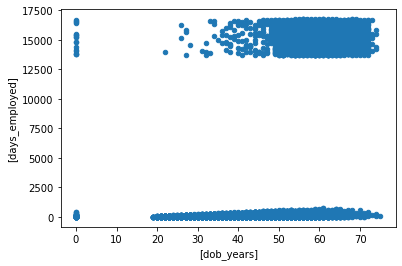

In [289]:
data.plot.scatter(x=['dob_years'], y=['days_employed']);

Распределение значений по трудовому стажу от возраста.

**гипотеза** строки со значениями days_employed меньше 2500 **удалить**

### Несущественно для этого исследования
Ходил в курилку, там повстречал заказчиков исследования.
Они и говорят:
 - слушай, бро!
 чё ты паришься со стажем? у тебя какое задание? стаж в нём имеет место быть?
 - посмотрел ТЗ
 " влияет ли семейное положение и количество детей"
 -- блин. так ведь действительно, вроде не существенно.
 
 - ладно. в порядок данные привёл, и хорошо. не будут смущать в процессе тзысканий

### 3. dob_years - возраст.


In [290]:
data['dob_years'].describe()

count   21,525.00
mean        43.29
std         12.57
min          0.00
25%         33.00
50%         42.00
75%         53.00
max         75.00
Name: dob_years, dtype: float64

Из общих данных известно, что:
- возвраст указан в годах
- это целочисленное значение
- среднее 43 года
- есть значения "0"
Значения "0" считаем ПРОПУСКОМ данных

In [291]:
data[data['dob_years'] == 0].count()

children            101
days_employed        91
dob_years           101
education           101
education_id        101
family_status       101
family_status_id    101
gender              101
income_type         101
debt                101
total_income         91
purpose             101
childhood            91
dtype: int64

Таких "пропусков" 101 строка, что составляет меньше одного процента от всех данных.

**гипотеза** Этими строками можно пренебречь, однако!
В ТЗ нет прямой отсылки к возрасту.
На этом этапе ничего не делаем.

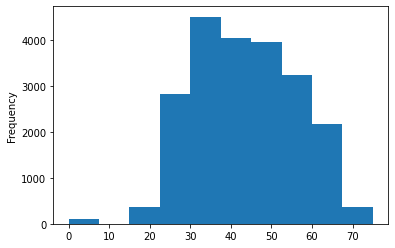

In [292]:
dob_year = data['dob_years']

dob_year.plot(kind='hist');

Замечательное распределение данных по возрасту.
Смело считаем значения меньше 10 лет - пропусками дангных. Принеобходимости можно заменить на NaN

### 4. education - образование.


Из общих справочных данных, по колонке Образование, следующие сведения:
- это строковое значение
- нет пропусков строк
- вероятно присутствие неявных дубликатов

Проверяю неявные дубликаты выводом уникальных значений

In [293]:
data['education'].unique()

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

Для удобного восприятия выведу отсортированный список в вертикальном расположении.

In [294]:
sorted(data['education'].unique())

['ВЫСШЕЕ',
 'Высшее',
 'НАЧАЛЬНОЕ',
 'НЕОКОНЧЕННОЕ ВЫСШЕЕ',
 'Начальное',
 'Неоконченное высшее',
 'СРЕДНЕЕ',
 'Среднее',
 'УЧЕНАЯ СТЕПЕНЬ',
 'Ученая степень',
 'высшее',
 'начальное',
 'неоконченное высшее',
 'среднее',
 'ученая степень']

Здесь видны неявные дубликаты

* высшее - ВЫСШЕЕ, Высшее
* начальное - НАЧАЛЬНОЕ, Начальное
* неоконченное высшее - НЕОКОНЧЕННОЕ ВЫСШЕЕ, Неоконченное высшее
* среднее - СРЕДНЕЕ, Среднее
* ученая степень - УЧЕНАЯ СТЕПЕНЬ, Ученая степень

Эти дубликаты поменяю на аналоги, написанные в нижнем регистре
Попробую применить метод перевода в нижний регистр всех значений

In [295]:
data['education'] = data['education'].str.lower()
sorted(data['education'].unique())

['высшее', 'начальное', 'неоконченное высшее', 'среднее', 'ученая степень']

#### Успех!
Посмотрим распределение уровня образования среди клиентов 

In [296]:
# data.plot(x='education', y='children',  kind='bar')
# подсчитываю количество строковых значений
unique_edu = sorted(data['education'].unique())
unique_edu

['высшее', 'начальное', 'неоконченное высшее', 'среднее', 'ученая степень']

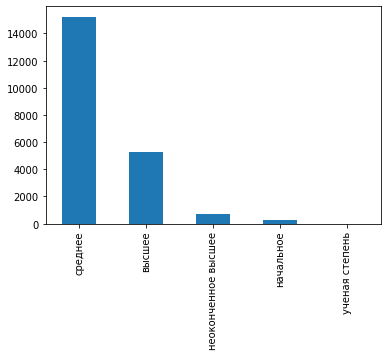

In [297]:
data['education'].value_counts().plot(kind='bar');

In [298]:
data['education'].sort_values().value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Эта информация в ТЗ не требуется. Но интересно же!

### 5. education_id - идентификатор уровня образования.


Задачи:
Проверить, сколько уникальных значений
Как они соотносятся со строковыми значениями уровня образования
В случае ошибок - исправить


In [299]:
sorted(data['education_id'].unique())

[0, 1, 2, 3, 4]

Прекрасно! Количество значений _id совпадает с количеством категорий в строковым формате
Теперь хочу проверить соответствие строковых и численных категорий.
Нет ли ошибок...

In [300]:
id_0 = data.loc[data.loc[:, 'education_id'] == 0]
id_0['education'].sort_values().value_counts()

высшее    5260
Name: education, dtype: int64

In [301]:
id_0 = data.loc[data.loc[:, 'education_id'] == 1]
id_0['education'].sort_values().value_counts()

среднее    15233
Name: education, dtype: int64

In [302]:
id_0 = data.loc[data.loc[:, 'education_id'] == 2]
id_0['education'].sort_values().value_counts()

неоконченное высшее    744
Name: education, dtype: int64

In [303]:
id_0 = data.loc[data.loc[:, 'education_id'] == 3]
id_0['education'].sort_values().value_counts()

начальное    282
Name: education, dtype: int64

#### Прекрасно!
Каждая числовая категория _id соответствует одному значению строковой категории


### Можно сделать словарь категория уровня образования
Из основной таблицы data убираем колонку education
И Создаём табличку 'education_dict' с колонками education_id и education

In [304]:
# новая табличка
education_dict = data[['education_id', 'education']]
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,1,среднее
3,1,среднее
4,1,среднее
...,...,...
21520,1,среднее
21521,1,среднее
21522,1,среднее
21523,1,среднее


In [305]:
# убираем дубликаты в словаре
education_dict = education_dict.drop_duplicates().reset_index(drop=True)
education_dict

,education_id,education
0,0,высшее
1,1,среднее
2,2,неоконченное высшее
3,3,начальное
4,4,ученая степень


Словарь education_dict готов!

Убираю лишнюю колонку из data

In [306]:
del data['education']
data

,children,days_employed,dob_years,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,childhood
0,1,351.57,42,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья,41.04
1,1,167.70,36,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,35.54
2,0,234.31,33,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья,32.36
3,3,171.86,32,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование,31.53
4,0,"14,177.75",53,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу,14.16
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,188.72,43,1,гражданский брак,1,F,компаньон,0,"224,791.86",операции с жильем,42.48
21521,0,"14,330.73",67,1,женат / замужем,0,F,пенсионер,0,"155,999.81",сделка с автомобилем,27.74
21522,1,88.06,38,1,гражданский брак,1,M,сотрудник,1,"89,672.56",недвижимость,37.76
21523,3,129.69,38,1,женат / замужем,0,M,сотрудник,1,"244,093.05",на покупку своего автомобиля,37.64


### 6. family_status - семейное положение.


#### Из общей справки по данным
- строковое значение
- пропусков нет


#### Получаю список уникальных значений

In [307]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

#### Прекрасные новости!
Всего встречается 5 значений
Неявных дубликатов нет

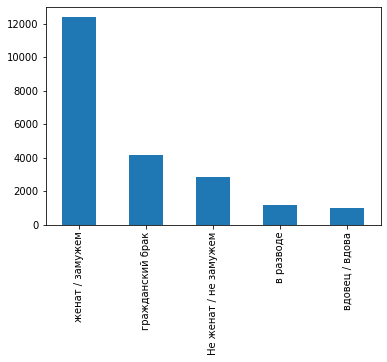

In [308]:
data['family_status'].value_counts().plot(kind='bar');

#### Можно переходить к следущей колонке

### 7. family_status_id - идентификатор семейного положения.


#### Из общей справки по данным
- целочисленный идентификатор семейного положения. можно сделать словарь
- пропусков нет


#### Посмотрим данные в отсортированном виде

In [309]:
data['family_status_id'].sort_values().value_counts()

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

#### Распределение значений

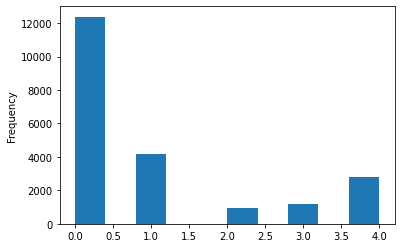

In [310]:
family_status_id = data['family_status_id']
family_status_id.plot(kind='hist');

### Для удобства оперирования данными, можно вывести колонку family_status в отдельный словарь

Из основной таблицы data убираем колонку family_status
И Создаём табличку 'family_status_dict' с колонками family_status_id и family_status

In [311]:
# новая табличка
family_status_dict = data[['family_status_id', 'family_status']]
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,0,женат / замужем
2,0,женат / замужем
3,0,женат / замужем
4,1,гражданский брак
...,...,...
21520,1,гражданский брак
21521,0,женат / замужем
21522,1,гражданский брак
21523,0,женат / замужем


In [312]:
# убираем дубликаты в словаре
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True)
family_status_dict

,family_status_id,family_status
0,0,женат / замужем
1,1,гражданский брак
2,2,вдовец / вдова
3,3,в разводе
4,4,Не женат / не замужем


Словарь family_status_dict готов!

Убираю лишнюю колонку из data

In [313]:
del data['family_status']
data

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood
0,1,351.57,42,0,0,F,сотрудник,0,"253,875.64",покупка жилья,41.04
1,1,167.70,36,1,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,35.54
2,0,234.31,33,1,0,M,сотрудник,0,"145,885.95",покупка жилья,32.36
3,3,171.86,32,1,0,M,сотрудник,0,"267,628.55",дополнительное образование,31.53
4,0,"14,177.75",53,1,1,F,пенсионер,0,"158,616.08",сыграть свадьбу,14.16
...,...,...,...,...,...,...,...,...,...,...,...
21520,1,188.72,43,1,1,F,компаньон,0,"224,791.86",операции с жильем,42.48
21521,0,"14,330.73",67,1,0,F,пенсионер,0,"155,999.81",сделка с автомобилем,27.74
21522,1,88.06,38,1,1,M,сотрудник,1,"89,672.56",недвижимость,37.76
21523,3,129.69,38,1,0,M,сотрудник,1,"244,093.05",на покупку своего автомобиля,37.64


### 8. gender - пол

#### Из общей справки по данным
- текстовый формат
- пропусков нет


#### Смотрим уникальные значения

In [314]:
data['gender'].sort_values().value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Женщины, женщины... Всё то они крутятся, вертятся...
И ещё странная ХНА
Пойду, проверю ЙЦУКЕН
* проверка на ЙЦУКЕН не дала вменяемого результата
Посмотрю всю строку с этим значением

In [315]:
print(data.loc[data.loc[:,'gender'] == 'XNA'])  

       children  days_employed  dob_years  education_id  family_status_id  \
10701         0          98.28         24             2                 1   

      gender income_type  debt  total_income               purpose  childhood  
10701    XNA   компаньон     0    203,905.16  покупка недвижимости      23.73  


Я предложил заказчику **удалить** эту единственную странную строку.
Заказчик согласился.

In [316]:
data = data.loc[data['gender'] != 'XNA']

#data.drop(data[data['gender'] == 'XNA'].index, inplace=True)

In [317]:
# контроль
data.reset_index(inplace=True)
data['gender'].sort_values().value_counts()

F    14236
M     7288
Name: gender, dtype: int64

In [318]:
data[10700:10703]

,index,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood
10700,10700,1,21.37,37,0,0,F,компаньон,0,"174,396.82",ремонт жилью,36.94
10701,10702,0,"16,191.93",60,1,1,F,пенсионер,0,"108,125.20",свадьба,15.64
10702,10703,0,150.83,35,1,0,F,сотрудник,0,"89,817.94",получение образования,34.59


### Успешно удалена странная строка из dataframe

### 9. income_type - тип занятости

#### Из общей справки по данным
- текстовый формат
- пропусков нет

#### Смотрим уникальные значения

In [319]:
data['income_type'].sort_values().value_counts()

сотрудник          11119
компаньон           5084
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

##### у нас получается "карманный банк" для своих, для сотрудников и компаньонов ?
нет. наверно всё-таки здесь ошибка в терминах

#### Прекрасная колонка! Ничего не надо делать )))

### 10. debt - имел ли задолженность по возврату. 

#### Из общей справки по данным
- текстовое
- пропусков нет

#### Смотрим уникальные значения

In [320]:
data['debt'].sort_values().value_counts()

0    19783
1     1741
Name: debt, dtype: int64

#### Вот, какие замечательные клиенты у банка!
Задолженности имели лишь...

In [321]:
print((1741/19783)*100, '%')

8.800485265126625 %


Много это или мало? Спрошу у бизнеса...

### 11. total_income - ежемесячный доход - численное

#### Из общей справки по данным
- вещественное
- есть пропуски. столько же ,сколько пропуков в колнке со стажем
- отрицательные значения отсутствуют

#### Смотрим в сортированном виде

In [322]:
data['total_income'].sort_values()

14584   20,667.26
13005   21,205.28
16173   21,367.65
1598    21,695.10
14275   21,895.61
           ...   
21488         nan
21494         nan
21496         nan
21501         nan
21509         nan
Name: total_income, Length: 21524, dtype: float64

#### Распределение возраст/доход

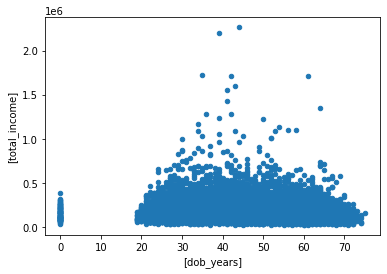

In [323]:
data.plot.scatter(x=['dob_years'], y=['total_income']);

#### Распределение стаж / доход

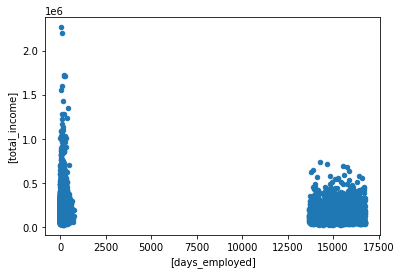

In [324]:
data.plot.scatter(x=['days_employed'], y=['total_income']);

Есть клиенты без указания стажа с высоким уровнем дохода.
Интересно посмотреть их тип занятости...

#### Соотношение образования и уровня дохода
* высшее
* среднее
* неоконченное высшее
* начальное
* ученая степень

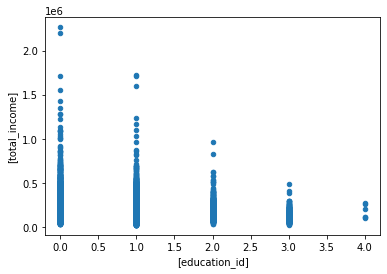

In [325]:
data.plot.scatter(x=['education_id'], y=['total_income']);

**Парадокс** - обладатели учёной степени заявляют самый низкий уровень дохода!

#### Соотношение семейного статуса и уровня дохода
* женат / замужем
* гражданский брак
* вдовец / вдова
* в разводе
* Не женат / не замужем

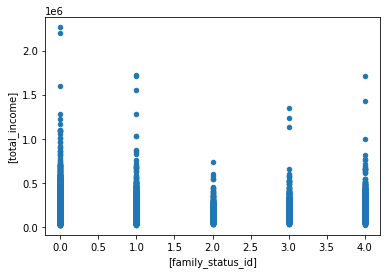

In [326]:
data.plot.scatter(x=['family_status_id'], y=['total_income']);

Интересная и совсем не однозначная картина.

#### Соотношение наличие задолженности и уровень дохода 
* нет задолженности
* есть задолженность

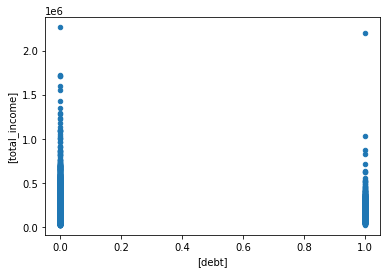

In [327]:
data.plot.scatter(x=['debt'], y=['total_income']);

С более высоким уровнем дохода - меньше задолженностей.

### <font color='blue'>Начну восполнять пробелы в данных о доходах</font>

На уровень дохода могут влиять
    * стаж
    * возраст
    * образование
    * пол
    * тип занятости
    
В данных о стаже у неас пропуски в тех же строках, что и данных о доходе.
Так что этот параметр в расчет точно не берём.

Пол. Ну... Во-первых, у нас среди клиентов преобладание женщин.
Во-вторых, в нашей стране уже значительно снизилась зависисимость заработка от пола "в среднем по больнице".
Так что этот параметр тоже пока отложим.

В сухом остатке
    - возраст
    - образование
    - тип занятости

Данные по образованию и типу занятости являются прямыми категориями.
Но возраст - это набор цифр.
Для анализа медианного значения дохода следует этот показатель свести к категориям.

По исследованию данных в первой части работы:
 * медиана = 43 года
 * минимум ~ 18 лет


Исследуем пропуски (згачение "0") в возрасте

In [328]:
# табличка с возрастом "0"
dob_years_0 = data[data['dob_years'] == 0]
dob_years_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 99 to 21312
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             101 non-null    int64  
 1   children          101 non-null    int64  
 2   days_employed     91 non-null     float64
 3   dob_years         101 non-null    int64  
 4   education_id      101 non-null    int64  
 5   family_status_id  101 non-null    int64  
 6   gender            101 non-null    object 
 7   income_type       101 non-null    object 
 8   debt              101 non-null    int64  
 9   total_income      91 non-null     float64
 10  purpose           101 non-null    object 
 11  childhood         91 non-null     float64
dtypes: float64(3), int64(6), object(3)
memory usage: 10.3+ KB


In [329]:
dob_years_0.describe()

,index,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,childhood
count,101.00,101.00,91.00,101.00,101.00,101.00,101.00,91.00,91.00
mean,"10,300.77",0.50,"2,896.50",0.00,0.67,1.24,0.08,"158,337.96",-7.94
std,"5,826.99",0.81,"5,900.53",0.00,0.51,1.52,0.27,"74,381.85",16.17
min,99.00,0.00,4.54,0.00,0.00,0.00,0.00,"34,974.45",-45.78
25%,"6,407.00",0.00,40.29,0.00,0.00,0.00,0.00,"99,582.87",-0.57
50%,"10,545.00",0.00,73.29,0.00,1.00,1.00,0.00,"152,419.18",-0.20
75%,"14,608.00",1.00,209.25,0.00,1.00,3.00,0.00,"212,549.42",-0.11
max,"21,313.00",3.00,"16,708.02",0.00,2.00,4.00,1.00,"386,373.64",-0.01


Что ж... всё очень похоже на случайное значение "0" в данных по возрасту.

Заполню медианными значениями по группам

Сначала заменю "0" на np.NaN

In [330]:
import numpy as np
data['dob_years'].replace(0, np.NaN, inplace = True)

In [331]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             21524 non-null  int64  
 1   children          21524 non-null  int64  
 2   days_employed     19350 non-null  float64
 3   dob_years         21423 non-null  float64
 4   education_id      21524 non-null  int64  
 5   family_status_id  21524 non-null  int64  
 6   gender            21524 non-null  object 
 7   income_type       21524 non-null  object 
 8   debt              21524 non-null  int64  
 9   total_income      19350 non-null  float64
 10  purpose           21524 non-null  object 
 11  childhood         19350 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.0+ MB


In [332]:
data.sort_values(['dob_years'])

,index,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood
1981,1981,0,30.19,19.00,1,4,F,компаньон,0,"59,124.07",свой автомобиль,18.92
15658,15659,0,39.51,19.00,2,1,F,компаньон,0,"167,211.39",на покупку подержанного автомобиля,18.89
13020,13021,0,29.00,19.00,2,4,F,компаньон,0,"165,269.03",автомобили,18.92
10235,10235,0,33.06,19.00,1,0,F,сотрудник,0,"131,308.78",ремонт жилью,18.91
9218,9218,0,13.42,19.00,1,1,F,компаньон,0,"103,676.48",сыграть свадьбу,18.96
...,...,...,...,...,...,...,...,...,...,...,...,...
19828,19829,0,nan,nan,1,0,F,сотрудник,0,nan,жилье,nan
20461,20462,0,"14,113.95",nan,1,0,F,пенсионер,0,"259,193.92",покупка своего жилья,-38.67
20576,20577,0,"13,822.55",nan,1,4,F,пенсионер,0,"129,788.76",недвижимость,-37.87
21178,21179,2,4.54,nan,0,0,M,компаньон,0,"240,702.01",строительство жилой недвижимости,-0.01


И меняем NaN на медианные значения по группам

In [333]:
data['dob_years'] = data.loc[:, 'dob_years'].fillna(data.groupby('family_status_id')['dob_years'].transform('median'))

In [334]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21524 entries, 0 to 21523
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             21524 non-null  int64  
 1   children          21524 non-null  int64  
 2   days_employed     19350 non-null  float64
 3   dob_years         21524 non-null  float64
 4   education_id      21524 non-null  int64  
 5   family_status_id  21524 non-null  int64  
 6   gender            21524 non-null  object 
 7   income_type       21524 non-null  object 
 8   debt              21524 non-null  int64  
 9   total_income      19350 non-null  float64
 10  purpose           21524 non-null  object 
 11  childhood         19350 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.0+ MB


In [335]:
data.sort_values(['dob_years'])

,index,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood
5563,5563,0,36.89,19.00,2,4,M,сотрудник,0,"91,098.23",покупка жилья для сдачи,18.90
4098,4098,0,4.66,19.00,1,1,M,компаньон,0,"91,876.75",на проведение свадьбы,18.99
12046,12047,0,42.51,19.00,1,4,M,сотрудник,1,"93,343.13",операции со своей недвижимостью,18.88
2725,2725,0,4.83,19.00,1,4,F,компаньон,0,"131,967.26",операции с коммерческой недвижимостью,18.99
10235,10235,0,33.06,19.00,1,0,F,сотрудник,0,"131,308.78",ремонт жилью,18.91
...,...,...,...,...,...,...,...,...,...,...,...,...
11531,11532,0,278.45,74.00,1,1,F,сотрудник,0,"98,945.91",сыграть свадьбу,73.24
2557,2557,0,"15,535.88",74.00,1,0,F,пенсионер,0,"42,927.30",автомобили,31.44
3460,3460,0,"14,359.33",74.00,1,0,M,пенсионер,0,"54,754.75",операции со своей недвижимостью,34.66
4895,4895,0,"14,230.34",74.00,0,0,F,пенсионер,0,"134,935.35",покупка своего жилья,35.01


### <font color='blue'>Заполняем пропуски дохода</font>

In [336]:
data['total_income'] = data['total_income'].fillna(data.groupby(['income_type', 'family_status_id', 'education_id'])['total_income'].transform('median'))

<font color='blue'>Спасибо. Учту.</font>

#### <font color='blue'>Вот что получилось</font>

#### Распределение возраст/доход


Стало

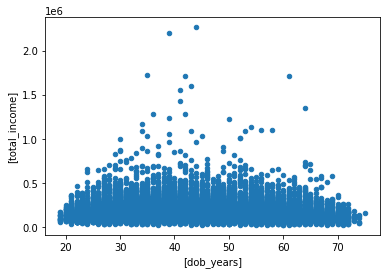

In [337]:
data.plot.scatter(x=['dob_years'], y=['total_income']);

### 12. purpose - цель получения кредита

#### Из общей справки по данным
- текстовое
- пропусков нет

#### Смотрим уникальные значения

In [338]:
data['purpose'].sort_values().value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      623
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Видим множество неявных дубликатов

#### Создам список уникальных значений

In [339]:
purpose_unique = data['purpose'].unique()
purpose_unique

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

# Предварительное знакомство с данными показало то, что кое-что в них было не так.


## children

### отрицательные значения
исправлено

### гигантское количество
убран "0" в числе

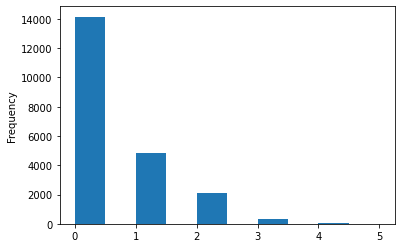

In [340]:
childrens.plot(kind='hist');

Прав Владимр Владимирович. Мало детей у нас...

## days_employed

### странные числа
методом сортировки вывлено минимальное количество, очень похожее на количество часов в сутках
значения заменены делением на 24

### отрицательные значения
отрицательные значения заменены на положительные

### пропущенные значения
пока оставлено без изменений

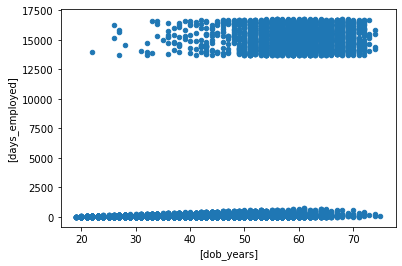

In [341]:
data.plot.scatter(x=['dob_years'], y=['days_employed']);

Безвозрастные умудрились наработать трудовой стаж.
<font color='blue'>Но мы уже избавились от безвозрастных - наградили их жизнью</font>

## dob_years

### пропущенные значения
пока оставлено без изменений

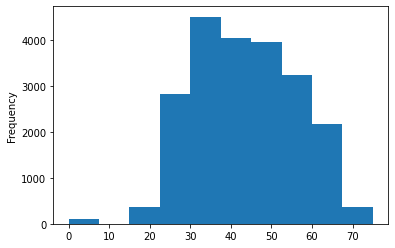

In [342]:
dob_year.plot(kind='hist');

Безвозрастных мало, а основная возрастная группа - 30 - 50 лет.

## education
только странно, что клиенты с учёной степенью имеют малый доход


### неявные дубликаты
из-за применения разного регистра
исправлено

### по сути, дублируется колонкой education_id
столбец удалён
сформирован словарь с education_id

## education_id
всё хорошо
сформирован словарь для education

## family_status  и family_status_id
сформирован словарь
излишний столбец family_status удалён

## gender
почти всё хорошо

### Успешно удалена странная строка из dataframe

In [343]:
data['gender'].sort_values().value_counts()

F    14236
M     7288
Name: gender, dtype: int64

## income_type
всё прекрасно

In [344]:
data['income_type'].sort_values().value_counts()

сотрудник          11119
компаньон           5084
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64

## debt
данные в отличном состоянии

In [345]:
data['debt'].sort_values().value_counts()

0    19783
1     1741
Name: debt, dtype: int64

Вот, какие замечательные клиенты у банка!

## total_income

### есть незначительное (~10%) количество пропусков
пока что пропуски оставил как есть

Распределение возраст/доход

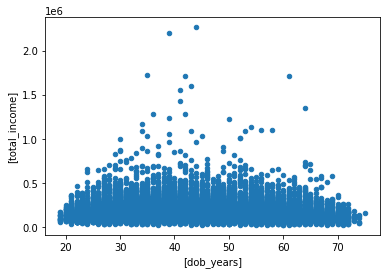

In [346]:
data.plot.scatter(x=['dob_years'], y=['total_income']);

## purpose
нет пропусков
есть неявные дубликаты

## Шаг 2. Предобработка данных

## Обработка пропусков


Для обработки пропусков, обратим внимание на вопросы, поставленные в качестве целей исследования.

Это
- Есть ли зависимость между наличием детей и возвратом кредита в срок?
- Есть ли зависимость между семейным положением и возвратом кредита в срок?
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
- Как разные цели кредита влияют на его возврат в срок?

Прорабатываем пропуски последовательно.

### ...детей ...

#### есть ли пропуски в детях?
из первого раздела известно, что данных о количестве детей, пропусков нет.
а со странными значениями уже справились

In [347]:
data['children'].value_counts()

0    14148
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

### ...семейное положение ...

#### есть ли пропуски в данных о семейном положении?
из первого раздела известно, что таких пропусков нет.
а со странными значениями уже справились

In [348]:
data['family_status_id'].value_counts()

0    12380
1     4176
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

### ...уровень дохода ...

#### есть ли пропуски в данных об уровне дохода?
из первого раздела известно, что такие пропуски есть.
посмотрим на них более пристально

In [349]:
data['total_income'].isna().sum()

2

2 строк пропуском значений

<font color='blue'>ДВЕ строки можно удалить без последствий для результатов анализа</font>

In [350]:
income_nan = data.loc[data['total_income'].isna()]
income_nan

,index,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood
5936,5936,0,nan,58.00,0,0,M,предприниматель,0,nan,покупка жилой недвижимости,nan
12406,12407,0,nan,57.00,2,3,F,пенсионер,0,nan,получение высшего образования,nan


Из принта видно, что Nan одновременно встречается в колонках days_employed и total_income (и вычесленном childhood)
всего 2 строки

<font color='blue'>Для предпринимателя и пенсионера не нашлось похожих )))</font>

In [351]:
print(income_nan['days_employed'].isna().sort_values())

5936     True
12406    True
Name: days_employed, dtype: bool


В отсортированном принте отсутсвуют False.
Это значит то, что во всех строках NaN для total_income также NaN и в days_employed

Посмотрим, как распределяются строки NaN в разрезе других колонок

In [352]:
# количество детей 
income_nan['children'].value_counts()

0    2
Name: children, dtype: int64

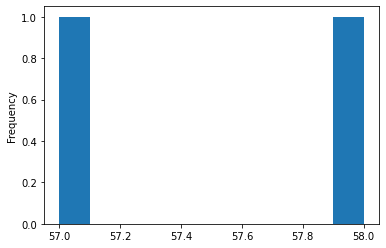

In [353]:
# возраст
income_nan['dob_years'].plot(kind='hist');

In [354]:
# тип занятости

income_nan['income_type'].value_counts()

пенсионер          1
предприниматель    1
Name: income_type, dtype: int64

Никаких аномалий не выявлено. Распределение примерно похоже на общее распределение данных по остальным показателям среди общей массы.

Для ответа на поставленный перед исследованием вопрос
- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
строки с пропущенными значениями в колонке total_income исключаем из анализа, принимая к сведению несущественное (<font color='blue'>ДВЕ</font>) их количество.
Имеем в виду, что одновременно в такой выборке данных также будут отсутвовать пропуски в колонке days_employed

(после создания колонки категорий целей кредитования)

### ...цель получения кредита ...

#### есть ли пропуски в данных о целях получения кредита?
из первого раздела известно, что таких пропусков нет.
также составлен словарь, в котором выделены категории целей


**Вывод**

Данные подготовлены для работы.

Для ответа на вопросы
* Есть ли зависимость между наличием детей и возвратом кредита в срок?
* Есть ли зависимость между семейным положением и возвратом кредита в срок?
* Как разные цели кредита влияют на его возврат в срок?
исследуем данные в data

Для ответа на вопрос 
* Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
исследуем data_not_na

### Замена типа данных

**Вывод**

для ответа на поставленные вопросы ти пы данных менять не надо.
для обработки целей кредитлования воспользуемся лемматизацией ниже

### Обработка дубликатов

Есть ли явные дубликаты в данных?

In [355]:
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


**Вывод**

## ! Явных дубликатов нет !
Неявные дубликаты обработаны ранее

### Лемматизация

In [356]:

from pymystem3 import Mystem
m = Mystem()

# проведём лемматизацию уникальных значений колонки purpose
# соберём уникальные значения purpose
purpose_unique = data['purpose'].unique()
purpose_unique


array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

38 уникальных значений для лемматизации

In [357]:
lemmas_series = []
for i in range(len(purpose_unique)):
    
    lemmas = m.lemmatize(purpose_unique[i])
    lemmas_series.append([lemmas])
    # print(lemmas)
    
print(lemmas_series)

[[['покупка', ' ', 'жилье', '\n']], [['приобретение', ' ', 'автомобиль', '\n']], [['дополнительный', ' ', 'образование', '\n']], [['сыграть', ' ', 'свадьба', '\n']], [['операция', ' ', 'с', ' ', 'жилье', '\n']], [['образование', '\n']], [['на', ' ', 'проведение', ' ', 'свадьба', '\n']], [['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n']], [['покупка', ' ', 'недвижимость', '\n']], [['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']], [['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']], [['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n']], [['недвижимость', '\n']], [['строительство', ' ', 'недвижимость', '\n']], [['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']], [['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']], [['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']], [['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n']], [['жилье', '\n']], [['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '

### Сделаем отбор в отдельные таблицы строк из data, в которых в purpose встречаются ключевые слова

In [358]:
# готовлю таблички для наполнения данными
data_1 = data # скопировал стркутуру и данные
# удаляю все строки
data_1 = data_1.loc[data_1['children'] < 0] # заведомо значение False
data_1

,index,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,childhood


In [359]:
# дублирую dataframe без строк в заготовки для группировки по ключевым словам
auto = data_1 # автомобиль
education = data_1 # образование
wedding = data_1 # свадьба
commercial_real_estate = data_1 # коммерческая недвижимость
real_estate_renovation = data_1 # ремонт жилья
real_estate = data_1 # недвижимость (частная)
no_label = data_1 # если не будет ключевых влов, включённых в отбор


In [360]:
len(data)

21524

In [361]:
%%time
def create_category_purpose(row):
    lem_purpose = m.lemmatize(row['purpose'])
    if 'автомобиль' in lem_purpose:
        return 'автомобиль'
    elif 'образование' in lem_purpose:
        return 'образование'
    elif 'свадьба'  in lem_purpose:
        return 'свадьба' 
    elif 'сдача'  in lem_purpose and 'жилье'  in lem_purpose:
        return 'коммерческая недвижимость'
    elif 'коммерческий' in lem_purpose and  'недвижимость'  in lem_purpose:
        return 'коммерческая недвижимость'
    elif 'ремонт'  in lem_purpose and  'недвижимость'  in lem_purpose:
        return 'ремонт недвижимости'
    elif 'ремонт'  in lem_purpose and  'жилье'  in lem_purpose:
        return 'ремонт недвижимости'
    elif 'недвижимость'  in lem_purpose:
        return 'недвижимость' 
    elif 'жилье'  in lem_purpose:
        return 'недвижимость' 
    else:
        return 'без группы'
    

# применяю функцию с созданием столбца purpose_category
data['purpose_category'] = data.apply(create_category_purpose, axis=1)
data['purpose_category'].sort_values().value_counts()


CPU times: user 922 ms, sys: 359 ms, total: 1.28 s
Wall time: 2.62 s


недвижимость                 8259
автомобиль                   4315
образование                  4022
свадьба                      2348
коммерческая недвижимость    1968
ремонт недвижимости           612
Name: purpose_category, dtype: int64

## Готовы отдельные срезы данных по целям запроса кредитов.

### Категоризация данных

в общем объёме исходных данных есть возможность выделения категорий в :
    -  образование, семейный статус, пол, тип занятости, цель кредитования
    
    Трансформация текстовых значений этих колонок выгодна для дальнейшей передачи в подразделение машинного обучения.
    (кроме цели кредитования)
    В текущих задачах мне удобнее работать с текстовыми значениями, в которых неявные дубликаты обработаны.
    Цель кредитования тоже удобно рассматривать в текстовом виде. Но сначала её проработал методами лемматизации и категоризации.

## Шаг 3. Ответьте на вопросы

# Уровень дохода.
Здесь для анализа влияния этого параметра на возвратность кредита следует выделить интервальные группы.
Посмотрим на расперделение по сумме за отсечением строк с отсутствующими данными.
это срез данных data_not_na

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [370]:
pd.options.display.float_format = '{:,.2f}'.format # установка формата вывода на дисплей численных значений

In [371]:
# сделал табличку без NaN в total_income
data_not_na = data.dropna(subset=['total_income'])

In [372]:
dept_0 = data_not_na[data_not_na['debt'] == 0] # отобрал строки с возвратом кредита

dept_1 = data_not_na[data_not_na['debt'] == 1] # отобрал строки без возврата кредита

dept_0['total_income'].describe()

count      19,781.00
mean      165,762.10
std        98,154.69
min        21,205.28
25%       107,659.93
50%       143,855.21
75%       197,783.26
max     2,265,604.03
Name: total_income, dtype: float64

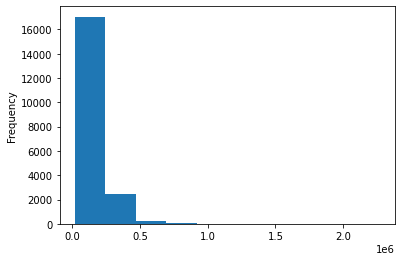

In [373]:
dept_0['total_income'].plot(kind = 'hist');

In [374]:
dept_1['total_income'].describe()

count       1,741.00
mean      161,042.93
std        97,817.13
min        20,667.26
25%       108,252.81
50%       140,638.62
75%       189,395.52
max     2,200,852.21
Name: total_income, dtype: float64

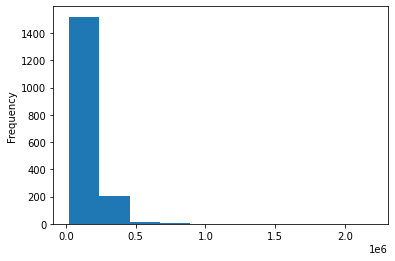

In [375]:
dept_1['total_income'].plot(kind = 'hist');

### Федеральная служба государственной статистики разделяет уровень жизни россиян в зависимости от доходов на следующие категории:
крайняя нищета (доходы ниже прожиточного минимума — до 7-8 тыс.р.)

нищета (доходы от одного до двух прожиточных минимума — от 8 до 12 тыс.р.)

бедность (доходы от 12 до 20 тысяч рублей в месяц)

выше бедности (доходы от 20 до 30 тысяч рублей в месяц)

средний достаток — (доходы от 30 до 60 тысяч рублей в месяц)

состоятельные — (доходы от 60 до 90 тысяч рублей в месяц)

богатые — (доходы от 90 тысяч рублей в месяц)

сверхбогатые — (доходы свыше 150 тысяч рублей в месяц)


в наших исследуемых данных есть уровни дохода от <font color='red'>"выше бедности"</font> до <font color='green'>"сверхбогатые"</font>

In [376]:
# выше бедности
total_income_20 = data_not_na[data_not_na['total_income'] > 20000]
total_income_20 = total_income_20[total_income_20['total_income'] <= 30000]

count = total_income_20['index'][total_income_20['debt'] == 1].count()
print('В категории выше бедности задолженность у', count, 'клиентов')
print(round((count / total_income_20['index'].count()) * 100, 2), '% от общего числа клиентов этой категории'    )
print()

#  средний достаток
total_income_30 = data_not_na[data_not_na['total_income'] > 30000]
total_income_30 = total_income_30[total_income_30['total_income'] <= 60000]

count = total_income_30['index'][total_income_30['debt'] == 1].count()
print('В категории средний достаток задолженность у', count, 'клиентов')
print(round((count / total_income_30['index'].count()) * 100, 2), '% от общего числа клиентов этой категории'    )
print()

# состоятельные
total_income_60 = data_not_na[data_not_na['total_income'] > 60000]
total_income_60 = total_income_60[total_income_60['total_income'] <= 90000]

count = total_income_60['index'][total_income_60['debt'] == 1].count()
print('В категории состоятельные задолженность у', count, 'клиентов')
print(round((count / total_income_60['index'].count()) * 100, 2), '% от общего числа клиентов этой категории'    )
print()

#  богатые
total_income_90 = data_not_na[data_not_na['total_income'] > 90000]
total_income_90 = total_income_90[total_income_90['total_income'] <= 150000]

count = total_income_90['index'][total_income_90['debt'] == 1].count()
print('В категории богатые задолженность у', count, 'клиентов')
print(round((count / total_income_90['index'].count()) * 100, 2), '% от общего числа клиентов этой категории'    )
print()

#  сверхбогатые
total_income_150 = data_not_na[data_not_na['total_income'] > 150000]

count = total_income_150['index'][total_income_150['debt'] == 1].count()
print('В категории сверхбогатые задолженность у', count, 'клиентов')
print(round((count / total_income_150['index'].count()) * 100, 2), '% от общего числа клиентов этой категории'    )


В категории выше бедности задолженность у 2 клиентов
9.09 % от общего числа клиентов этой категории

В категории средний достаток задолженность у 47 клиентов
5.99 % от общего числа клиентов этой категории

В категории состоятельные задолженность у 213 клиентов
8.38 % от общего числа клиентов этой категории

В категории богатые задолженность у 707 клиентов
8.66 % от общего числа клиентов этой категории

В категории сверхбогатые задолженность у 772 клиентов
7.71 % от общего числа клиентов этой категории


### ВЫВОД. Уровень дохода тоже влияет на возвратность кредитов
<font color='red'>Самый ненадёжный сегмент - малоимущие (выше бедности)</font>

<font color='green'>Надёжный сегмент - средний достаток</font>

<font color='blue'>Сверхбюогатые - редкий случай и обнадёживающий</font>

# Количество детей
Те же выборки:
* dept_0
* dept_1


- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [377]:
dept_0['children'].describe()

count   19,781.00
mean         0.47
std          0.75
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          5.00
Name: children, dtype: float64

In [378]:
dept_1['children'].describe()

count   1,741.00
mean        0.54
std         0.78
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         4.00
Name: children, dtype: float64

In [379]:
dept_0['children'].value_counts() # количества категорий

0    13083
1     4420
2     1929
3      303
4       37
5        9
Name: children, dtype: int64

In [380]:
dept_1['children'].value_counts() # количества категорий

0    1063
1     445
2     202
3      27
4       4
Name: children, dtype: int64

In [381]:
data_not_na['children'].value_counts() # количества категорий всего

0    14146
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

In [383]:
print('Имеют задолженности по количеству детей')
for i in range(len(data['children'].value_counts())):
    
    print(round(((dept_1['index'][dept_1['children'] == i].count())
       / ((dept_0['index'][dept_0['children'] == i].count()) 
          + (dept_1['index'][dept_1['children'] == i].count()))) 
       * 100, 2), '% в семье', i, 'реб.')


Имеют задолженности по количеству детей
7.51 % в семье 0 реб.
9.15 % в семье 1 реб.
9.48 % в семье 2 реб.
8.18 % в семье 3 реб.
9.76 % в семье 4 реб.
0.0 % в семье 5 реб.


### ВЫВОД. Количество детей имеет некоторое влияние на возвратность кредитов
<font color='red'>Самый ненадёжный сегмент - два ребенка</font>

<font color='green'>Надёжный сегмент - трое детей и бездетные</font>

<font color='blue'>Пятеро детей - редкий случай и надёжный</font>


# Семейное положение
Те же выборки:
* dept_0
* dept_1


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [384]:
dept_0['family_status_id'].value_counts() # количества категорий

0    11448
1     3788
4     2539
3     1109
2      897
Name: family_status_id, dtype: int64

In [385]:
dept_1['family_status_id'].value_counts() # количества категорий

0    931
1    388
4    274
3     85
2     63
Name: family_status_id, dtype: int64

    А теперь возьму в долях от общего количества по каждой категории

In [386]:

print('Общее число клиентов по категориям')


data_not_na['family_status_id'].value_counts()

Общее число клиентов по категориям


0    12379
1     4176
4     2813
3     1194
2      960
Name: family_status_id, dtype: int64

In [388]:
print('Имеют задолженности по категориям')
print('клиенты разного семейного статуса:')

for i in range(len(family_status_dict)):
    print(round(((dept_1['index'][dept_1['family_status_id'] == i].count())
       / ((dept_0['index'][dept_0['family_status_id'] == i].count()) 
          + (dept_1['index'][dept_1['family_status_id'] == i].count()))) 
       * 100, 2), "%", family_status_dict['family_status'][i])

Имеют задолженности по категориям
клиенты разного семейного статуса:
7.52 % женат / замужем
9.29 % гражданский брак
6.56 % вдовец / вдова
7.12 % в разводе
9.74 % Не женат / не замужем


**Вывод**

Семейное положение имеет значение

### ВЫВОД. Семейное положение имеет значение на возвратность кредитов
<font color='red'>Самый ненадёжный сегмент - не женат / не замужем</font>

<font color='green'>Самый надёжный сегмент - вдовец / вдова</font>

<font color='blue'>Разведённые и семейные - примерно рядом</font>


# Цели кредитования
Те же выборки:
* dept_0
* dept_1


- Как разные цели кредита влияют на его возврат в срок?

In [389]:
dept_0['purpose_category'].value_counts() # количества категорий

недвижимость                 7662
автомобиль                   3912
образование                  3651
свадьба                      2162
коммерческая недвижимость    1817
ремонт недвижимости           577
Name: purpose_category, dtype: int64

In [390]:
dept_1['purpose_category'].value_counts() # количества категорий

недвижимость                 596
автомобиль                   403
образование                  370
свадьба                      186
коммерческая недвижимость    151
ремонт недвижимости           35
Name: purpose_category, dtype: int64

In [391]:
print('Имеют задолженности по категориям')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'недвижимость'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'недвижимость'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'недвижимость'].count()))) * 100, 2), '% недвижимость')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'автомобиль'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'автомобиль'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'автомобиль'].count()))) * 100, 2), '% автомобиль')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'образование'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'образование'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'образование'].count()))) * 100, 2), '% образование')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'свадьба'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'свадьба'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'свадьба'].count()))) * 100, 2), '% свадьба')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'коммерческая недвижимость'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'коммерческая недвижимость'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'коммерческая недвижимость'].count())))\
             * 100, 2), '% коммерческая недвижимость')
print(round(((dept_1['index'][dept_1['purpose_category'] == 'ремонт недвижимости'].count())/\
    ((dept_0['index'][dept_0['purpose_category'] == 'ремонт недвижимости'].count())+\
        (dept_1['index'][dept_1['purpose_category'] == 'ремонт недвижимости'].count())))\
             * 100, 2), '% ремонт недвижимости')

print('от общего числа клиентов этой категории')



Имеют задолженности по категориям
7.22 % недвижимость
9.34 % автомобиль
9.2 % образование
7.92 % свадьба
7.67 % коммерческая недвижимость
5.72 % ремонт недвижимости
от общего числа клиентов этой категории


### ВЫВОД. Цель кредитования имеет значение на возвратность кредитов
<font color='red'>Самый ненадёжный сегмент - автомобиль</font>

<font color='green'>Самый надёжный сегмент - недвижимость</font>

<font color='blue'>Свадьба - тоже хорошая цель по возвратности</font>

<font color='red'>А вот образование лишь ненамного надёжнее, чем автомобиль</font>

## Шаг 4. Общий вывод

По результатам исследования можно отметить влияние на возврастность кредитов всех рассматриваемых факторов

## <font color='red'>Самый высокорисковый клиент:</font>
С низким доходом, двумя детьми, с целью на автомобиль


In [392]:
print('Таких клиентов в банке ....', data['index'][(data['debt'] == 0) &\
     (data['total_income'] <= 30000) & (data['children'] == 2) & \
        (data['purpose_category'] == 'автомобиль')].count(), '!!!')

Таких клиентов в банке .... 0 !!!


## <font color='blue'>Прекрасная работа отдела продаж!</font>
Повысим ставки. Следующая "вилка" в доходах: до 60000 р

In [393]:
print('В банке', data['index'][(data['total_income'] <= 60000) & (data['children'] == 2)\
     & (data['purpose_category'] == 'автомобиль')].count()
, "таких клиентов, а с проблемой по возврату из них -", data['index'][(data['debt'] == 1)\
     & (data['total_income'] <= 60000) & (data['children'] == 2) & \
        (data['purpose_category'] == 'автомобиль')].count()
, 'то есть процент невозврата', round((data['index'][(data['debt'] == 1) &\
     (data['total_income'] <= 60000) & (data['children'] == 2) &\
         (data['purpose_category'] == 'автомобиль')].count()*100)/data['index'][(data['total_income']\
             <= 60000) & (data['children'] == 2) & (data['purpose_category'] == \
                'автомобиль')].count(), 2), '%')

В банке 12 таких клиентов, а с проблемой по возврату из них - 4 то есть процент невозврата 33.33 %


## <font color='blue'>33 % огромная цифра!</font>

## <font color='green'>Самый низкокорисковый клиент:</font>
С более, чем средним достатком, с тремя детьми, семейные, с целью кредитования на недвижимость 

In [394]:
print('В банке', data['index'][(data['total_income'] >= 60000) & (data['children'] == 3) & \
    (data['purpose_category'] == 'недвижимость')].count()
, "таких клиентов, а с проблемой по возврату из них -", data['index'][(data['debt'] == 1) & \
    (data['total_income'] >= 60000) & (data['children'] == 3) & (data['purpose_category'] == 'недвижимость')].count()
, 'то есть процент невозврата', round((data['index'][(data['debt'] == 1) & \
    (data['total_income'] >= 60000) & (data['children'] == 3) & \
        (data['purpose_category'] == 'недвижимость')].count()*100)/data['index'][(data['total_income'] >= 60000) &\
             (data['children'] == 3) & (data['purpose_category'] == 'недвижимость')].count(), 2), '%')

В банке 123 таких клиентов, а с проблемой по возврату из них - 10 то есть процент невозврата 8.13 %
